# Import Statements
For required libraries.

In [1]:
# Import statements
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3

## Check dataset proportions
By looking at the number of items.

In [2]:
# Dataset Directories for Fauna
TRAINING_DIR = "../datasets/flora/flowers/train"
VALIDATION_DIR = "../datasets/flora/flowers/val"

# Fauna Labels
FLORA_LABELS = next(os.walk(TRAINING_DIR))[1]
print(FLORA_LABELS)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Observing the first three animal images.

Flora: daisy
Training images: 611
Validation images: 153
Sample daisy image:


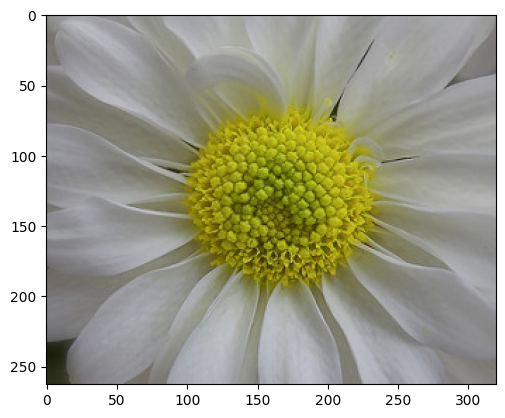


Flora: dandelion
Training images: 841
Validation images: 211
Sample dandelion image:


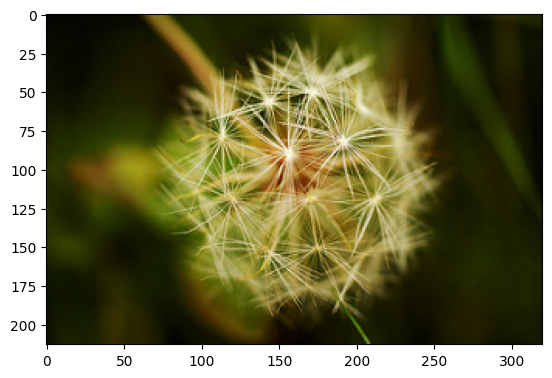


Flora: rose
Training images: 627
Validation images: 157
Sample rose image:


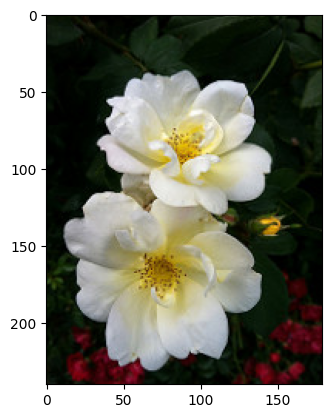

In [3]:
for flora in FLORA_LABELS[0:3]:
    # preparing directories
    train_flora_dir = os.path.join(TRAINING_DIR, flora)
    val_flora_dir = os.path.join(VALIDATION_DIR, flora)
    # displaying the results
    print(f"Flora: {flora}")
    print(f"Training images: {len(os.listdir(train_flora_dir))}")
    print(f"Validation images: {len(os.listdir(val_flora_dir))}")
    print(f"Sample {flora} image:")
    plt.imshow(load_img(f"{os.path.join(train_flora_dir, os.listdir(train_flora_dir)[0])}"))
    plt.show()
    print()

# Preprocessing the dataset
By using TensorFlow's ImageDataGenerator.

Create dataset generators, and augment the training dataset.

In [4]:
def train_val_generators(train_dir, valid_dir, image_size):
    # Train dataset will be augmented as follows
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest')
    # Initialize training generator
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        batch_size=64, 
                                                        class_mode='categorical',
                                                        target_size=(image_size, image_size))
    
    # Validation dataset will not be augmented 
    validation_datagen = ImageDataGenerator(rescale=1./255)
    # Initialize validation generator
    validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                                    batch_size=64, 
                                                                    class_mode='categorical',
                                                                    target_size=(image_size, image_size))
    return train_generator, validation_generator

In [5]:
IMAGE_SIZE = 225
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


# Model
Create a model using transfer learning.

## InceptionV3
Model creation.

Initialize InceptionV3

In [6]:
def create_inception_base_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
                                    include_top = False, 
                                    weights = None) 
    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    return pre_trained_model

In [7]:
local_weights_file = '../models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_base_model = create_inception_base_model(local_weights_file)

In [8]:
def output_of_last_layer(inception_base_model):
    last_desired_layer = inception_base_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

inception_last_layer = output_of_last_layer(inception_base_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [9]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)

  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(5, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [10]:
model = create_final_model(inception_base_model, inception_last_layer)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 65,665,189 total parameters in this model.
There are 56,689,925 trainable parameters in this model.


Callback class.

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

## Model Training and Evaluation

In [13]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/15
54/54 [==============================] - 148s 3s/step - loss: 1.1043 - accuracy: 0.6014 - val_loss: 0.5395 - val_accuracy: 0.7896
Epoch 2/15
54/54 [==============================] - 128s 2s/step - loss: 0.5914 - accuracy: 0.7842 - val_loss: 0.4586 - val_accuracy: 0.8127
Epoch 3/15
54/54 [==============================] - 124s 2s/step - loss: 0.5155 - accuracy: 0.8189 - val_loss: 0.3653 - val_accuracy: 0.8566
Epoch 4/15
54/54 [==============================] - 127s 2s/step - loss: 0.4363 - accuracy: 0.8410 - val_loss: 0.3731 - val_accuracy: 0.8671
Epoch 5/15
54/54 [==============================] - 131s 2s/step - loss: 0.4106 - accuracy: 0.8554 - val_loss: 0.3414 - val_accuracy: 0.8798
Epoch 6/15
54/54 [==============================] - 122s 2s/step - loss: 0.3605 - accuracy: 0.8705 - val_loss: 0.3838 - val_accuracy: 0.8786
Epoch 7/15
54/54 [==============================] - 128s 2s/step - loss: 0.3540 - accuracy: 0.8763 - val_loss: 0.3207 - val_accuracy: 0.8925
Epoch 8/15
54

## Model Plotting

Text(0.5, 1.0, 'Training and validation loss')

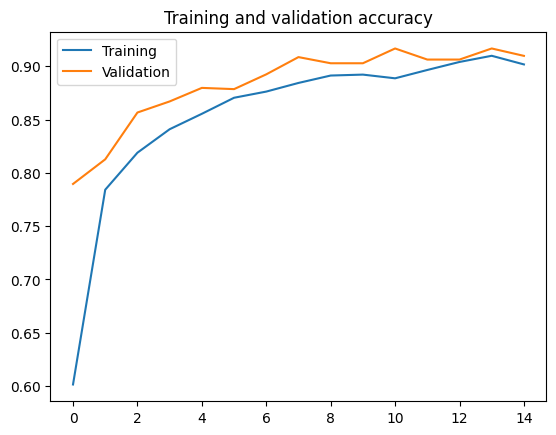

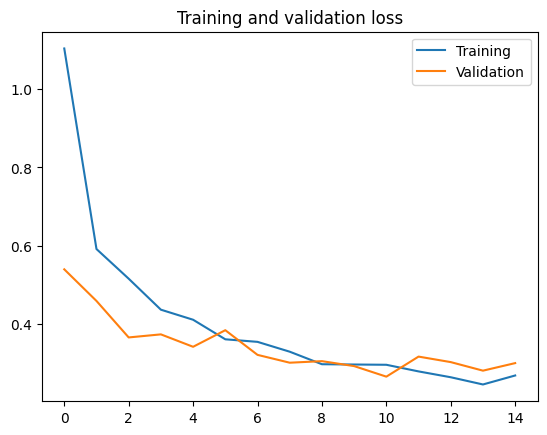

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

## Model Saving
As Keras HDF5 file.

In [15]:
import time
curr_time = int(time.time())
saved_model_path = f"../models/flora/flower/{curr_time}-flower5.h5"

model.save(saved_model_path)
# model.save(saved_model_path[:-3])